In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-09-03 07:05:22--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.100.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.100.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  48.3MB/s    in 31s     

2021-09-03 07:05:53 (50.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [4]:
filename = 'books.csv'

In [21]:
df = pd.read_csv(filename)

In [22]:
df.head(3)

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


In [23]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']
df.head(3)

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


In [15]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
def remove_non_ascii(s):
    return "".join(i for i in s if  ord(i)<128)

In [9]:
def make_lower_case(text):
    return text.lower()

In [10]:
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [11]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [12]:
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [24]:
df['cleaned'] = df['Desc'].apply(remove_non_ascii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [25]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [26]:
# 빈 값이 생긴 행
df['cleaned'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [27]:
df.shape

(2381, 7)

In [28]:
# 토큰화
corpus = [words.split() for words in df.cleaned]

## 사전 훈련된 워드 임베딩 사용

In [30]:
word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

## 단어 벡터의 평균 구하기

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [33]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 2381


## 추천 시스템

In [34]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [38]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(row['title'])

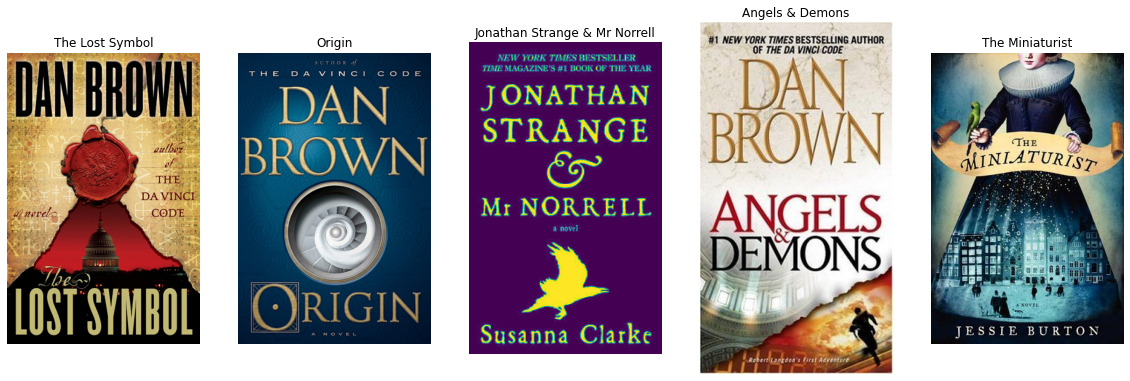

In [40]:
recommendations("The Da Vinci Code")

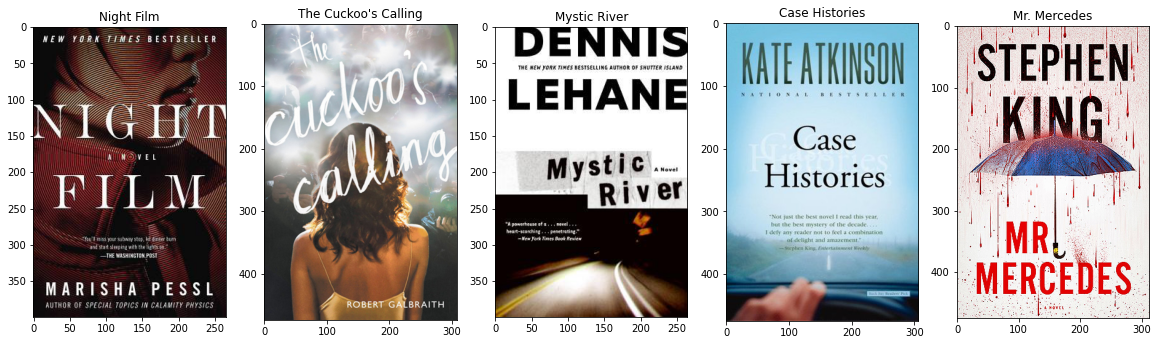

In [37]:
recommendations("The Murder of Roger Ackroyd")